<h1>Content</h1>

<ul>
  <li><a href="#Prep">Prep</a></li>
  <li><a href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a></li>
  <li><a href="#Training">Training</a></li>
  <li><a href="#Testing">Testing</a></li>
</ul>

#  Airport Taxi Demand Forecasting

**Task:** A taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak load periods, we need to learn how to predict the number of taxi orders for the next hour.

**Goal:** to get the RMSE metric on the test set to not exceed 48.

The data is in the file `taxi.csv`. The number of orders is in the column `num_orders`.

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression

from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [29]:
df = pd.read_csv('taxi.csv')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


## Prep

Convert the column with dates to the `datetime` type, then setting it as an index and resampling by one hour.

In [31]:
df.index = df['datetime'].astype('datetime64[ns]')

In [32]:
df = df.drop('datetime', axis=1)
df.sort_index(inplace=True)

In [33]:
df = df.resample('1H').sum()

## Exploratory Data Analysis

In [34]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:00:00'))

We have data for 6 months: from March 1st to August 31st. Let's take a look at the resampling by 1 week.

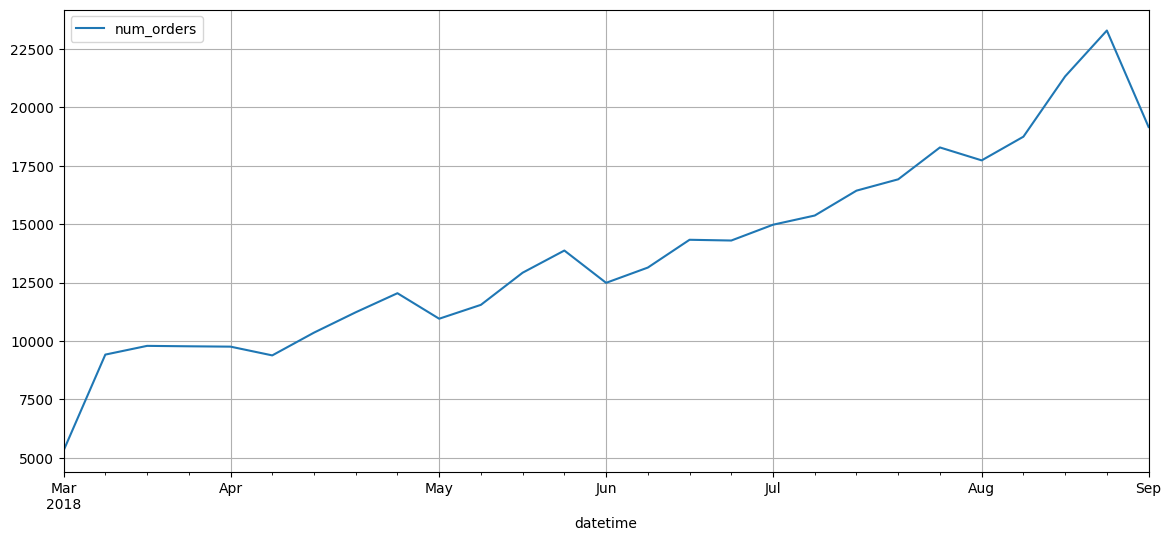

In [35]:
df[['num_orders']].resample('1W').sum().plot(figsize=(14,6))
plt.grid(True)

Strictly speaking, our series is not stationary because it not only has a trend but also an acceleration (quadratic trend) starting from August. The variance is also not constant.

However, there are methods that can help transform the series into a stationary one. For example, by taking the difference of the time series, we can remove the trend. Applying a Box-Cox transformation can help eliminate variance heterogeneity. Taking the difference over seasonality can remove seasonal effects.

The models I'm planning on using are capable of predicting the series without all these transformations. So I don't necessarily need to perform them. We can simply test whether it's possible to transform the series into a stationary one.

We'll be using the Dickey-Fuller test to determine whether a time series is stationary (strictly by definition, it is not, but we'll see whether it can be transformed into one).

In [36]:
st_test = adfuller(df['num_orders'], regression='ctt')

print('If the value with index 1 in lower than P-Value, then the series is stationary.\n')
if st_test[1] < 0.05:
    print('The series is stationary')
else:
    print('The series is not stationary')

If the value with index 1 in lower than P-Value, then the series is stationary.

The series is stationary


Our series is stationary so simple models such as linear regression may work best. Now let's check for monotonicity.

In [37]:
df.index.is_monotonic_increasing

True

We have monotonicity!

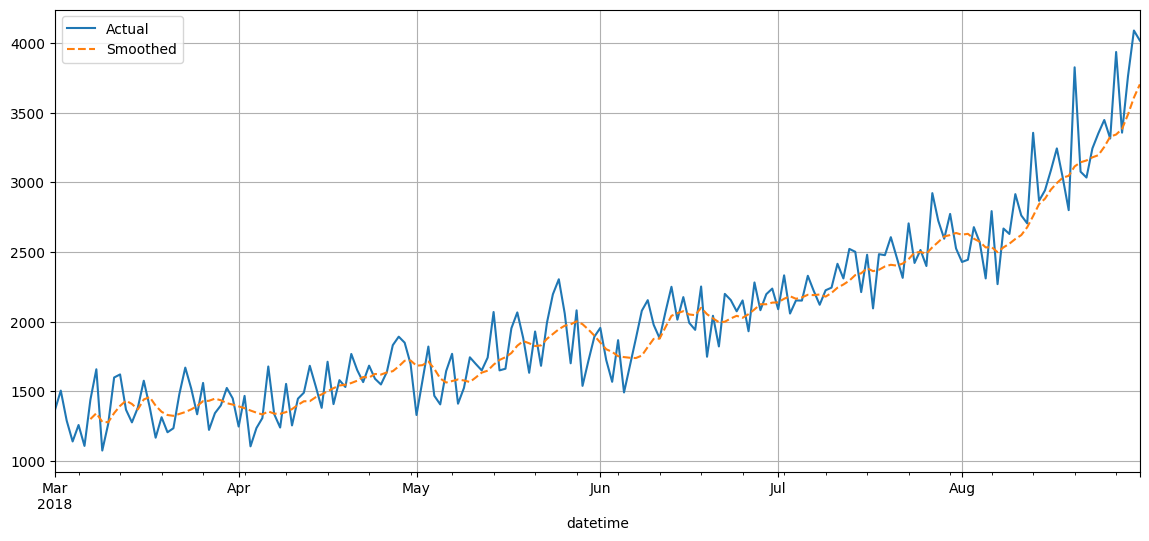

In [38]:
df_resampled = df[['num_orders']].resample('1D').sum()

df_resampled['num_orders'].plot(figsize=(14,6), label='Actual')
df_resampled['num_orders'].rolling(window=7).mean().plot(label='Smoothed', linestyle='--')

plt.grid(True)
plt.legend()
plt.show()

When we take a rolling window over a week, it doesn't show monotonicity in the mathematical sense, but the trend of increasing orders is still noticeable.

The acceleration of the trend in August – let's assume this is due to yearly seasonality and the vacation season. Considering we are analyzing taxi data at airports, this assumption seems reasonable.

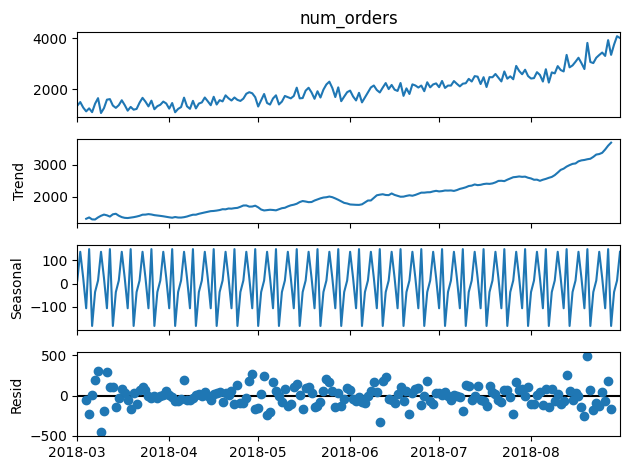

In [39]:
seasonal_decompose(df['num_orders'].resample('1D').sum(), model='additive').plot();

The residuals seem to be randomly scattered without significant deviations. That's good. And we can see a seasonal component: a weekly trend!

Let's add additional features for analysis: the hour of the order and the day of the week. And plot more graphs.

In [40]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek

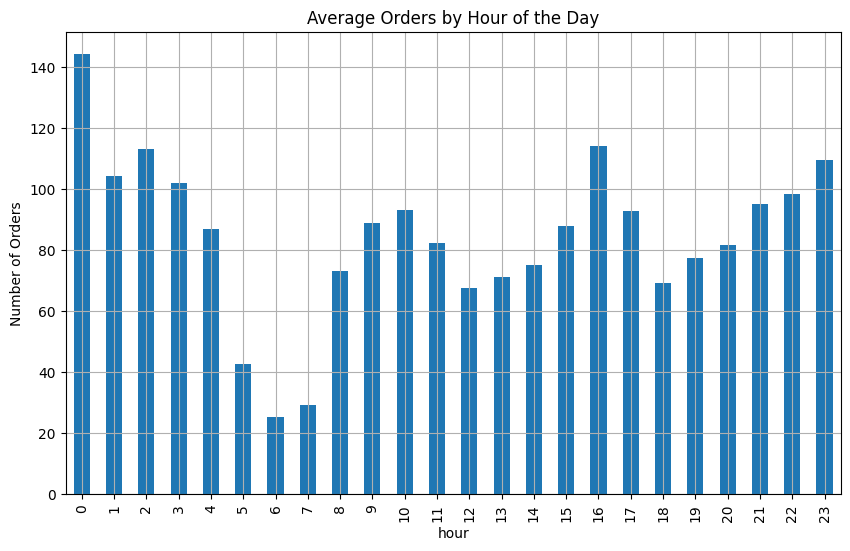

In [41]:
plt.figure(figsize=(10, 6))
df.groupby('hour')['num_orders'].mean().plot(kind='bar', title='Average Orders by Hour of the Day')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

At 6 a.m., there are the fewest orders, and the most occur at midnight. It's interesting that during the day, there are as many orders as at night.

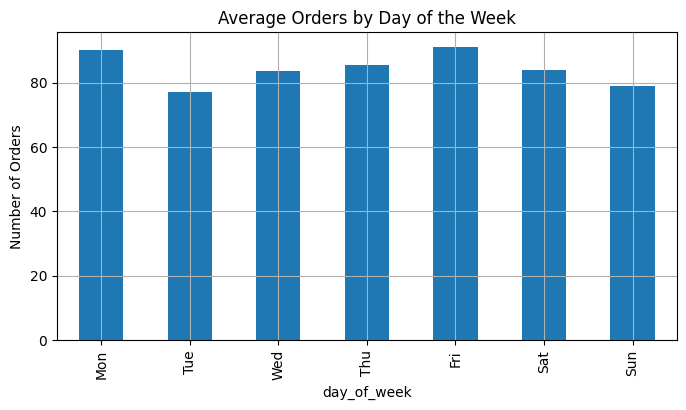

In [42]:
plt.figure(figsize=(8, 4))
df.groupby('day_of_week')['num_orders'].mean().plot(kind='bar', title='Average Orders by Day of the Week')
plt.ylabel('Number of Orders')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()

The fluctuations are small but not significant, the values remain on average around 80-90 orders per day. The highest number of orders occurs on Monday and Friday.

Using the autocorrelation function (ACF) as it shows at which intervals the time series repeats.

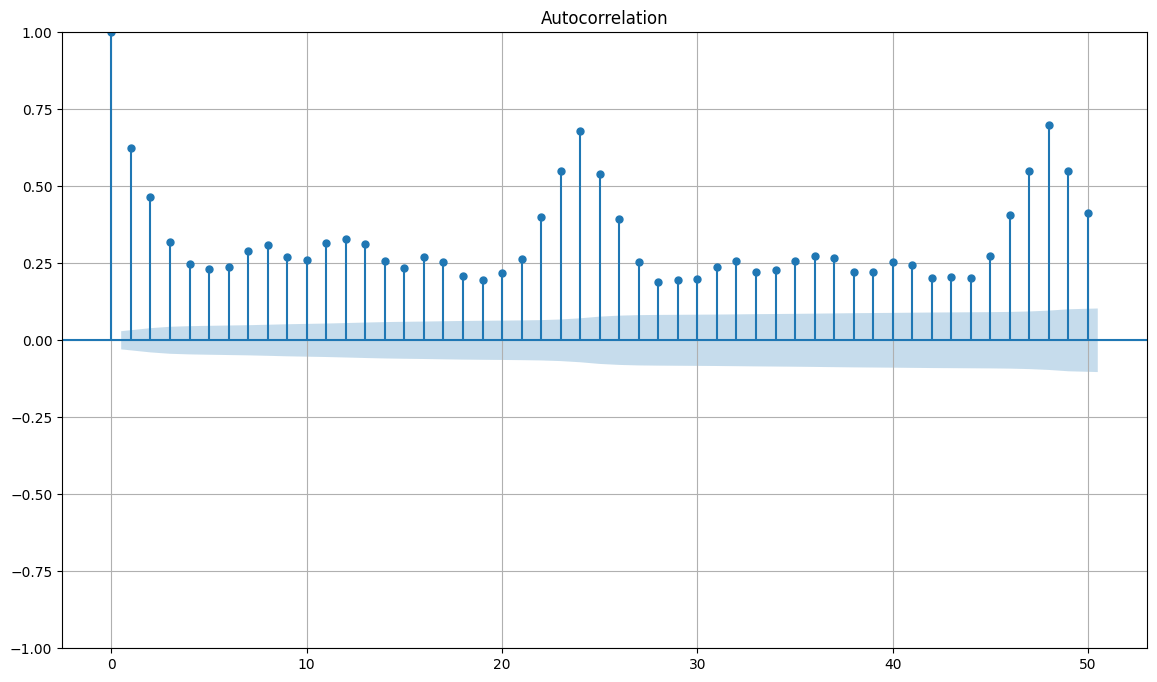

In [43]:
fig, ax = plt.subplots(figsize=(14, 8))
plot_acf(df['num_orders'], lags=50, ax=ax)
plt.grid(True)
plt.show();

Our data is grouped by hours, and we observe a recurring pattern every 24 hours. There is daily seasonality.

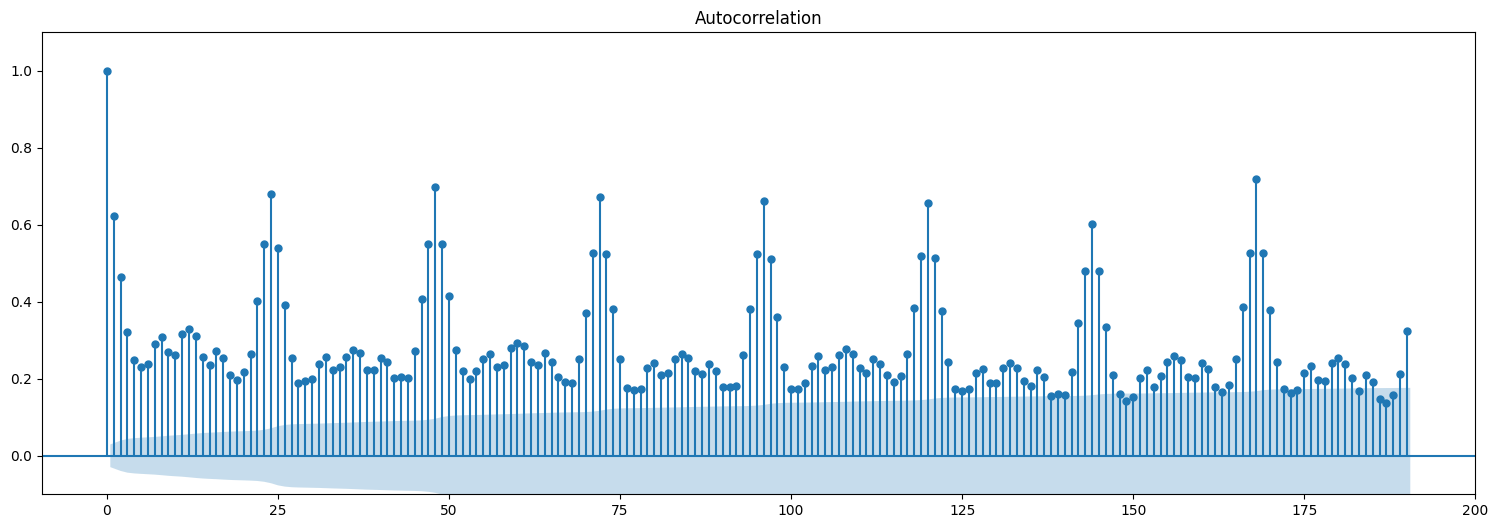

In [44]:
fig = tsaplots.plot_acf(df['num_orders'],lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show();

There is also weekly seasonality.

We have identified daily and weekly seasonality, so we will use lags for 168 hours (a week). This will help avoid target leakage.

In [45]:
for lag in range(1, 169):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

df['rolling_mean'] = df['num_orders'].shift(1).rolling(168).mean()

<ipython-input-45-28627ca3267a>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
<ipython-input-45-28627ca3267a>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
<ipython-input-45-28627ca3267a>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

Let's take a look at the correlation of the lags with the target feature (number of orders).

In [46]:
df[['num_orders', 'hour', 'lag_24', 'lag_168']].corr()

,num_orders,hour,lag_24,lag_168
num_orders,1.000000,0.004292,0.691576,0.805569
hour,0.004292,1.000000,0.004107,0.005252
lag_24,0.691576,0.004107,1.000000,0.658818
lag_168,0.805569,0.005252,0.658818,1.000000


The values from the same hour of the previous week and the previous day strongly correlate with the number of orders! (as expected)

In [48]:
df.dropna(inplace=True)

In [49]:
df.head()

,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,54.226190
2018-03-08 01:00:00,78,1,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,54.339286
2018-03-08 02:00:00,65,2,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,54.297619
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,54.261905
2018-03-08 04:00:00,60,4,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,54.273810


## Training

I don't need to perform any transformations for Linear Regression. I'll be simply extracting the target variable and then splitting the data into training and testing sets with a 9:1 ratio.

In [50]:
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [52]:
df.shape

(4248, 172)

In [53]:
print(f'Dataset length before splitting: {df.shape}')
print(f'Training set size: X_train: {X_train.shape}, y_train: {len(y_train)}')
print(f'Testing set size: X_test: {X_test.shape}, y_test: {len(y_test)}')

Dataset length before splitting: (4248, 172)
Training set size: X_train: (3823, 171), y_train: 3823
Testing set size: X_test: (425, 171), y_test: 425


Let's first take a look at the RMSE when predicting with the previous value (shift by 1) and with a constant (we'll use the median).

This will give us a baseline for comparison before applying more complex models.

In [54]:
y_pred_previous = y_test.shift(1).fillna(y_test.mean()) # filling the first value with a mean
y_pred_constant = np.full_like(y_test, y_test.median())

rmse_previous = np.sqrt(mean_squared_error(y_test, y_pred_previous))
rmse_constant = np.sqrt(mean_squared_error(y_test, y_pred_constant))

print(f'RMSE for y_pred_previous: {round(np.sqrt(mean_squared_error(y_test, y_pred_previous)))}')
print(f'RMSE for y_pred_constant: {round(np.sqrt(mean_squared_error(y_test, y_pred_constant)))}')

RMSE for y_pred_previous: 59
RMSE for y_pred_constant: 59


Now let's use linear regression.

In [55]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

print('RMSE on train:', round(np.sqrt(mean_squared_error(y_train, (lin_reg_model.predict(X_train))))))
print('RMSE on test:', round(np.sqrt(mean_squared_error(y_test, (lin_reg_model.predict(X_test))))))

RMSE on train: 20
RMSE on test: 34


In [56]:
tscv = TimeSeriesSplit(n_splits=3)

lin_reg_model = LinearRegression()

scores = cross_val_score(lin_reg_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

print('RMSE on cross validation:', rmse_scores)
print('Mean RMSE on cross validation:', round(rmse_scores.mean()))

RMSE on cross validation: [21.38055792 21.31824634 26.9524245 ]
Mean RMSE on cross validation: 23


The Lin Reg result is better than when we used a constant, good.

Additionally, I tried boosting models (XGBoost and LightGBM) but they turned out to not be better than Linear Regression, even after hyperparameter tuning with Optuna.

## Testing

In [61]:
lin_reg_model.fit(X_train, y_train)
rmse = round(np.sqrt(mean_squared_error(y_test, (lin_reg_model.predict(X_test)))))
print('RMSE on test:', rmse)

RMSE on test: 34


In [62]:
print(f'RMSE to median ratio: {rmse / y_train.median():.2f}')

RMSE to median ratio: 0.45


The RMSE on the test set is higher than on the training set which is normal, and significantly lower than the median: the error is 45% of the median, indicating strong model performance.

In [63]:
lin_reg_pred = lin_reg_model.predict(X_test)

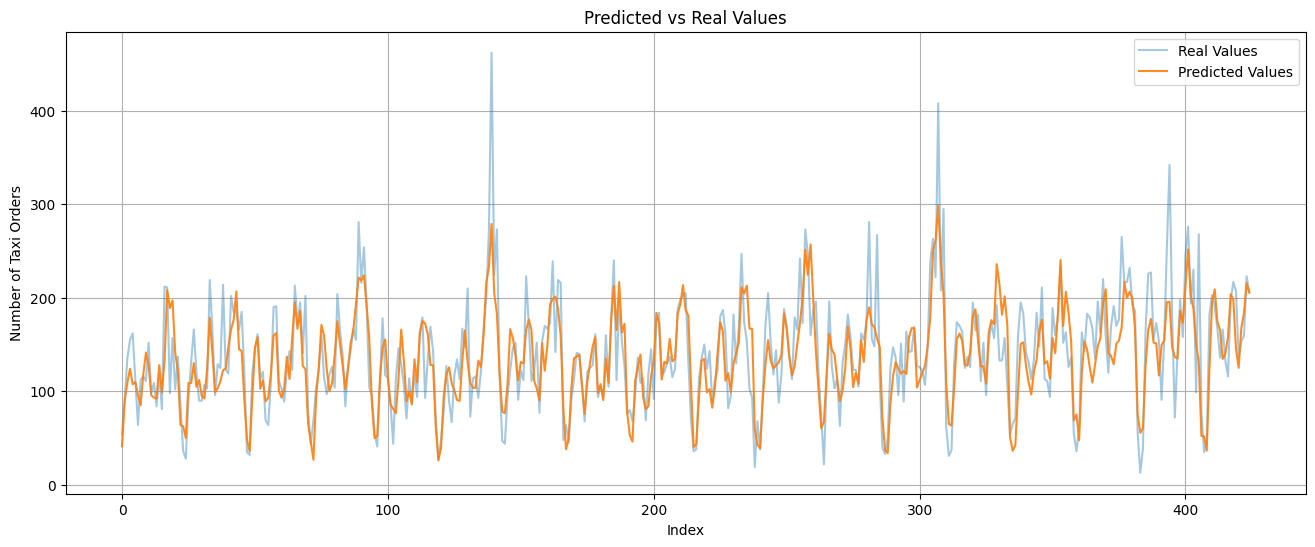

In [64]:
plt.figure(figsize=(16, 6))

plt.plot(np.arange(len(y_test)), y_test, label='Real Values', alpha=0.4)
plt.plot(np.arange(len(lin_reg_pred)), lin_reg_pred, label='Predicted Values', alpha=0.9)

plt.title('Predicted vs Real Values')
plt.xlabel('Index')
plt.ylabel('Number of Taxi Orders')
plt.legend()
plt.grid(True)

plt.show()

It seems that the model captures the general trends quite well!


# Conclusion

*Key Actions:*
1. Converted datetime, resampled hourly, identified daily/weekly seasonality, and tested stationarity.
2. Created lag features and rolling means, which improved model performance by capturing autocorrelation and seasonality.
3. Linear Regression outperformed complex models (XGBoost, LightGBM). Time series cross-validation ensured robustness.
4. Achieved RMSE well below the target (45% of the median), showing strong predictive performance.

*Key Takeaways:*
- Seasonality is crucial for time series.
- Simpler models like Linear Regression can outperform when feature engineering is solid.
- Baseline comparisons help measure real model improvement.